In [1]:
%load_ext autoreload
%autoreload 2

from run_models import load_model
from plot_utils import *
from DisruptionPredictors import DisruptionPredictorSM, DisruptionPredictorRF, DisruptionPredictorTinguely

from evaluate_performance import benchmark_au_roc, benchmark_true_detection

horizons = np.linspace(0.001, 0.5, 11)

device = 'cmod'
#dataset = 'random100'
dataset = 'random_256_shots_50%_flattop'
numeric_feats = ['ip','Wmhd','n_e','kappa','li']
#temporal_suff = ['_avg', '_std', '_int', '_der']
#temporal_feats = [feat + suff for feat in numeric_feats for suff in temporal_suff]

#device = 'synthetic'
#dataset = 'synthetic100'
#numeric_feats = ['ip', 'n_e', 'aminor', 'kappa', 'squareness', 'delta', 'li', 'Wmhd']


In [2]:
# Load models and create disruption predictors

cph_model, cph_transformer = load_model('cph', device, dataset)
cph_predictor = DisruptionPredictorSM("Cox Proportional Hazards", cph_model, numeric_feats, cph_transformer)

dcph_model, dcph_transformer = load_model('dcph', device, dataset)
dcph_predictor = DisruptionPredictorSM("Deep Cox Proportional Hazards", dcph_model, numeric_feats, dcph_transformer)

dsm_model, dsm_transformer = load_model('dsm', device, dataset)
dsm_predictor = DisruptionPredictorSM("Deep Survival Machines", dsm_model, numeric_feats, dsm_transformer)

dcm_model, dcm_transformer = load_model('dcm', device, dataset)
dcm_predictor = DisruptionPredictorSM("Deep Cox Mixture", dcm_model, numeric_feats, dcm_transformer)

#rsf_model, rsf_transformer = load_model('rsf', device, dataset)
#rsf_predictor = DisruptionPredictorSM("Random Survival Forest", rsf_model, numeric_feats, rsf_transformer)

rf_model, rf_transformer = load_model('rf', device, dataset)
rf_predictor = DisruptionPredictorRF("Random Forest", rf_model, numeric_feats, rf_transformer)

ting_model, ting_transformer = load_model('rf', device, dataset)
ting_predictor = DisruptionPredictorTinguely("Tinguely et al. 2019", ting_model, numeric_feats, ting_transformer)



Loaded model from models/cph_cmod_random_256_shots_50%_flattop.pkl
Loaded model from models/dcph_cmod_random_256_shots_50%_flattop.pkl
Loaded model from models/dsm_cmod_random_256_shots_50%_flattop.pkl
Loaded model from models/dcm_cmod_random_256_shots_50%_flattop.pkl
Loaded model from models/rf_cmod_random_256_shots_50%_flattop.pkl
Loaded model from models/rf_cmod_random_256_shots_50%_flattop.pkl


In [5]:
au_rocs_cph = benchmark_au_roc(cph_predictor, horizons, device, dataset+'_test')
au_rocs_dcph = benchmark_au_roc(dcph_predictor, horizons, device, dataset+'_test')
au_rocs_dcm = benchmark_au_roc(dcm_predictor, horizons, device, dataset+'_test')
au_rocs_dsm = benchmark_au_roc(dsm_predictor, horizons, device, dataset+'_test')
#au_rocs_rsf = benchmark_au_roc(rsf_predictor, horizons, device, dataset+'_test')
au_rocs_rf = benchmark_au_roc(rf_predictor, horizons, device, dataset+'_test')
#au_rocs_ting = benchmark_au_roc(ting_predictor, horizons, device, dataset+'_test')

print(au_rocs_cph)
print(au_rocs_dcph)
print(au_rocs_dcm)
print(au_rocs_dsm)
#print(au_rocs_rsf)
print(au_rocs_rf)
#print(au_rocs_ting)

[0.5324453551912568, 0.5078949410304159, 0.501287773241282, 0.4970048635757609, 0.49012791991101223, 0.4880200838979391, 0.484921468218882, 0.48250518417231236, 0.4771807967313586, 0.47389908814589665, 0.4720006927806483]
[0.5448922282938676, 0.5365132940202773, 0.5431706532899581, 0.5437574274822881, 0.5376930249296603, 0.5409356358377878, 0.5493018715001474, 0.5526949220537798, 0.5534525025536261, 0.5515732522796353, 0.5519579713073348]
[0.5128832726168792, 0.5300537968135733, 0.5349289045457531, 0.5248155033519238, 0.5162292252829942, 0.5178565348825124, 0.5225111135671481, 0.5283610952588131, 0.5278677221654751, 0.5256133738601824, 0.5218046935888925]
[0.6163289313904068, 0.5677051003517484, 0.5695069124901904, 0.5741862966808041, 0.5687528626578551, 0.5703339611044711, 0.5779346571372433, 0.5819946773947486, 0.5835150663942799, 0.5784097264437689, 0.573031203995035]
[0.5569880843958713, 0.5647695530726257, 0.5876532795868064, 0.598325781780235, 0.6067290862396126, 0.61048921350609

In [45]:
cph_temporal_model, cph_temporal_transformer = load_model('cph_temporal', device, dataset)
cph_temporal_predictor = DisruptionPredictorSM("Cox Proportional Hazards", cph_temporal_model, numeric_feats + temporal_feats, cph_temporal_transformer)

dcph_temporal_model, dcph_temporal_transformer = load_model('dcph_temporal', device, dataset)
dcph_temporal_predictor = DisruptionPredictorSM("Deep Cox Proportional Hazards", dcph_temporal_model, numeric_feats + temporal_feats, dcph_temporal_transformer)



Loaded model from models/cph_temporal_cmod_random100.pkl
Loaded model from models/dcph_temporal_cmod_random100.pkl


In [46]:
au_rocs_cph_temporal = benchmark_au_roc(cph_temporal_predictor, horizons, device, dataset+'_test')
au_rocs_dcph_temporal = benchmark_au_roc(dcph_temporal_predictor, horizons, device, dataset+'_test')

print(au_rocs_cph_temporal)
print(au_rocs_dcph_temporal)

[0.23076923076923073, 0.1923076923076923, 0.31868131868131866, 0.4175824175824175, 0.489010989010989, 0.5054945054945055, 0.4725274725274725, 0.4725274725274725, 0.489010989010989, 0.489010989010989, 0.489010989010989]
[0.5769230769230769, 0.30769230769230765, 0.25274725274725274, 0.25274725274725274, 0.18681318681318676, 0.09890109890109888, 0.10989010989010986, 0.10439560439560439, 0.14835164835164832, 0.17032967032967028, 0.1703296703296703]


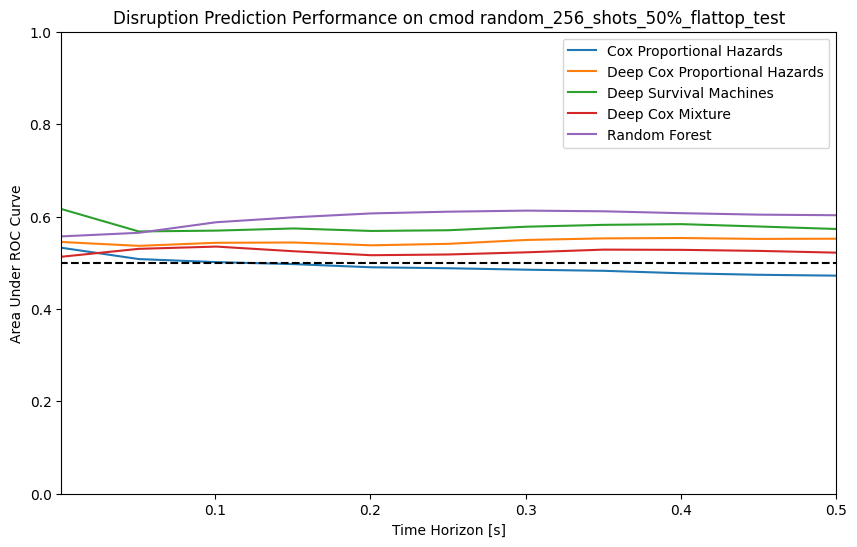

In [6]:
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(horizons, au_rocs_cph, label='Cox Proportional Hazards')
plt.plot(horizons, au_rocs_dcph, label='Deep Cox Proportional Hazards')
plt.plot(horizons, au_rocs_dsm, label='Deep Survival Machines')
plt.plot(horizons, au_rocs_dcm, label='Deep Cox Mixture')
#plt.plot(horizons, au_rocs_rsf, label='Random Survival Forest')
plt.plot(horizons, au_rocs_rf, label='Random Forest')
#plt.plot(horizons, au_rocs_ting, label='Tinguely et al. 2019')

#plt.plot(horizons, au_rocs_cph_temporal, label='Cox Proportional Hazards (temporal)')
#plt.plot(horizons, au_rocs_dcph_temporal, label='Deep Cox Proportional Hazards (temporal)')

# Plot horizontal line at y = 0.5 for reference to 'random guessing'
plt.plot([0, 1], [0.5, 0.5], linestyle='--', color='black')

plt.xlim([min(horizons), max(horizons)])
plt.ylim([0, 1.0])

plt.xlabel('Time Horizon [s]')
plt.ylabel('Area Under ROC Curve')
plt.title('Disruption Prediction Performance on '+device+' '+dataset+'_test')

plt.legend()
plt.show()



In [26]:
horizon = 0.02
amoc_cph = benchmark_true_detection(cph_predictor, horizon, device, dataset+'_test')
amoc_dcph = benchmark_true_detection(dcph_predictor, horizon, device, dataset+'_test')
amoc_dcm = benchmark_true_detection(dcm_predictor, horizon, device, dataset+'_test')
amoc_dsm = benchmark_true_detection(dsm_predictor, horizon, device, dataset+'_test')
#amoc_rsf = benchmark_true_detection(rsf_predictor, horizon, device, dataset+'_test')
amoc_rf = benchmark_true_detection(rf_predictor, horizon, device, dataset+'_test')
#amoc_ting = benchmark_true_detection(ting_predictor, horizon, device, dataset+'_test')


c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.ve

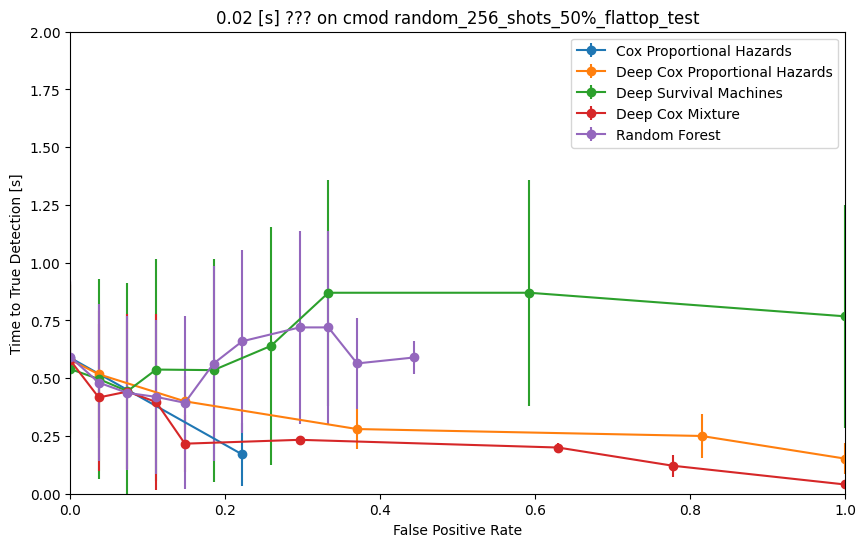

In [27]:
plt.figure(figsize=(10, 6))
plt.errorbar(amoc_cph[0], amoc_cph[1], yerr=amoc_cph[2], label='Cox Proportional Hazards', fmt='o-')
plt.errorbar(amoc_dcph[0], amoc_dcph[1], yerr=amoc_dcph[2], label='Deep Cox Proportional Hazards', fmt='o-')
plt.errorbar(amoc_dsm[0], amoc_dsm[1], yerr=amoc_dsm[2], label='Deep Survival Machines', fmt='o-')
plt.errorbar(amoc_dcm[0], amoc_dcm[1], yerr=amoc_dcm[2], label='Deep Cox Mixture', fmt='o-')
#plt.errorbar(amoc_rsf[0], amoc_rsf[1], yerr=amoc_rsf[2], label='Random Survival Forest', fmt='o-')
plt.errorbar(amoc_rf[0], amoc_rf[1], yerr=amoc_rf[2], label='Random Forest', fmt='o-')
#plt.errorbar(amoc_ting[0], amoc_ting[1], yerr=amoc_ting[2], label='Tinguely et al. 2019', fmt='o-')

plt.xlim([0, 1])
plt.ylim([0, 2])

plt.xlabel('False Positive Rate')
plt.ylabel('Time to True Detection [s]')
plt.title(f'{horizon} [s] ??? on {device} {dataset}_test')

plt.legend()
plt.show()

In [1]:
horizon = 0.1
amoc_cph = benchmark_true_detection(cph_predictor, horizon, device, dataset+'_test')
amoc_dcph = benchmark_true_detection(dcph_predictor, horizon, device, dataset+'_test')
amoc_dcm = benchmark_true_detection(dcm_predictor, horizon, device, dataset+'_test')
amoc_dsm = benchmark_true_detection(dsm_predictor, horizon, device, dataset+'_test')
amoc_rsf = benchmark_true_detection(rsf_predictor, horizon, device, dataset+'_test')
amoc_rf = benchmark_true_detection(rf_predictor, horizon, device, dataset+'_test')
amoc_ting = benchmark_true_detection(ting_predictor, horizon, device, dataset+'_test')


NameError: name 'benchmark_true_detection' is not defined